In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.stattools import adfuller  # 单位根检验
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox  # 白噪声检验

# 绘图支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

data1 = pd.read_excel('C_附件1.xlsx',sheet_name='企业的订货量（m³）')
data2 = pd.read_excel('C_附件1.xlsx',sheet_name='供应商的供货量（m³）')

t = pd.period_range('2017-2-1', periods=240, freq='w')
index = pd.PeriodIndex(t,freq='d')

data1_T = data1.T.iloc[2:,:]
data2_T = data2.T.iloc[2:,:]
data1_T.index=index
data2_T.index=index


In [2]:
def get_pdq(dy_24):
    '模型定阶'
    
    p = q =range(0,2)
    d = range(0,2)
    pdq = list(itertools.product(p,d,q))
    seasonal_pdq = [(x[0],x[1],x[2],24) for x in list(itertools.product(p,d,q))]
    out = []
    for param in pdq:
        for ps in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(dy_24,
                                               order=param,
                                               seasonal_order=ps,
                                               enforce_stationarity=False,
                                               enforce_invertibility=False)
                results = mod.fit()
#                 print('ARIMA{}*{} - AIC:{}'.format(param,ps,results.aic))
                out.append([param,ps,results.aic])
            except:
                continue
    return out

In [3]:
def forecast_y(par,dy):
    '预测'
    aic = pd.DataFrame([x[2] for x in par])
    i = aic.idxmin().loc[0]
    order = par[i][0]
    seasonal_order = par[i][1]
    mod = sm.tsa.statespace.SARIMAX(dy,
                                               order=order,
                                               seasonal_order=seasonal_order,
                                               enforce_stationarity=False,
                                               enforce_invertibility=False)
    results = mod.fit()
    pre = results.predict()
    forecast = results.forecast(24)
    return forecast,pre

In [21]:
# 预测24周的供货量
out = pd.DataFrame()
fore_out=pd.DataFrame()
for n in range(data2_T.shape[1]):#
    print('正在预测第 {} 个供货商,请稍候...'.format(n+1),end='    ')
    y = data2_T.iloc[:,n]
    dy_24 = y.diff(24).dropna().astype('float')
    
    # 模型定阶
    par = get_pdq(dy_24)
    
    aic = pd.DataFrame([x[2] for x in par])
    i = aic.idxmin().loc[0]
    order = par[i][0]
    seasonal_order = par[i][1]
    print(' --> 最优预测模型为：ARIMA{}*{}'.format(order,seasonal_order))
    
    # 向后预测24周
    fore,pre=forecast_y(par,dy_24)
    
    #还原数据
    t = pd.period_range('2021-9-12', periods=24, freq='w')
    index = pd.PeriodIndex(t,freq='d')
    fore.index = index
    tem = y[-24:].copy()
    tem.index = index
#     y = data2_T.iloc[:,n]
#     forecast =pd.concat([y,fore+tem])
#     plt.figure(figsize=[16,6])
#     plt.plot(forecast.dropna(),'g')
#     plt.plot(y,'r')
#     plt.show()
    te = fore.astype('int')+tem
    te[te<0]=0
    new_y = pd.concat([y.shift(24).dropna().astype('float')+pre.astype('float'),te],axis=0)
    new_y[new_y<0]=0
    
    out['S'+str(n+1).zfill(3)] = te
    fore_out['S'+str(n+1).zfill(3)] = new_y
    
out.index = ['第'+ str(i+1).zfill(2) + '周' for i in range(24)]
out.T.to_excel('供货量预测结果_24周.xlsx')

fore_out.index = ['第'+ str(i+25).zfill(2) + '周' for i in range(240)]
fore_out.T.to_excel('供货量预测结果_全部.xlsx')

正在预测第 1 个供货商,请稍候...     --> 最优预测模型为：ARIMA(0, 0, 1)*(1, 0, 1, 24)
正在预测第 2 个供货商,请稍候...     --> 最优预测模型为：ARIMA(0, 0, 1)*(1, 1, 1, 24)
正在预测第 3 个供货商,请稍候...     --> 最优预测模型为：ARIMA(1, 1, 1)*(1, 1, 1, 24)
正在预测第 4 个供货商,请稍候...     --> 最优预测模型为：ARIMA(1, 0, 1)*(0, 0, 1, 24)
正在预测第 5 个供货商,请稍候...     --> 最优预测模型为：ARIMA(1, 0, 1)*(1, 1, 1, 24)
正在预测第 6 个供货商,请稍候...     --> 最优预测模型为：ARIMA(1, 0, 1)*(1, 0, 1, 24)
正在预测第 7 个供货商,请稍候...     --> 最优预测模型为：ARIMA(1, 1, 1)*(1, 1, 1, 24)
正在预测第 8 个供货商,请稍候...     --> 最优预测模型为：ARIMA(0, 0, 1)*(1, 0, 1, 24)
正在预测第 9 个供货商,请稍候...     --> 最优预测模型为：ARIMA(0, 0, 1)*(0, 0, 1, 24)
正在预测第 10 个供货商,请稍候...     --> 最优预测模型为：ARIMA(1, 0, 1)*(1, 1, 1, 24)
正在预测第 11 个供货商,请稍候...     --> 最优预测模型为：ARIMA(1, 0, 1)*(1, 0, 1, 24)
正在预测第 12 个供货商,请稍候...     --> 最优预测模型为：ARIMA(1, 0, 0)*(0, 0, 1, 24)
正在预测第 13 个供货商,请稍候...     --> 最优预测模型为：ARIMA(0, 0, 0)*(1, 0, 1, 24)
正在预测第 14 个供货商,请稍候...     --> 最优预测模型为：ARIMA(0, 0, 1)*(1, 0, 1, 24)
正在预测第 15 个供货商,请稍候...     --> 最优预测模型为：ARIMA(1, 1, 1)*(1, 0, 1, 24)
正在预测第 16 个供货商,请稍候..

正在预测第 125 个供货商,请稍候...     --> 最优预测模型为：ARIMA(0, 0, 1)*(1, 0, 1, 24)
正在预测第 126 个供货商,请稍候...     --> 最优预测模型为：ARIMA(1, 1, 1)*(1, 1, 1, 24)
正在预测第 127 个供货商,请稍候...     --> 最优预测模型为：ARIMA(1, 0, 1)*(0, 0, 1, 24)
正在预测第 128 个供货商,请稍候...     --> 最优预测模型为：ARIMA(0, 0, 1)*(1, 0, 1, 24)
正在预测第 129 个供货商,请稍候...     --> 最优预测模型为：ARIMA(0, 0, 1)*(1, 1, 1, 24)
正在预测第 130 个供货商,请稍候...     --> 最优预测模型为：ARIMA(1, 0, 1)*(1, 0, 1, 24)
正在预测第 131 个供货商,请稍候...     --> 最优预测模型为：ARIMA(0, 1, 1)*(1, 1, 1, 24)
正在预测第 132 个供货商,请稍候...     --> 最优预测模型为：ARIMA(1, 0, 1)*(1, 0, 1, 24)
正在预测第 133 个供货商,请稍候...     --> 最优预测模型为：ARIMA(0, 0, 1)*(0, 0, 1, 24)
正在预测第 134 个供货商,请稍候...     --> 最优预测模型为：ARIMA(0, 0, 0)*(0, 0, 1, 24)
正在预测第 135 个供货商,请稍候...     --> 最优预测模型为：ARIMA(0, 1, 1)*(1, 1, 1, 24)
正在预测第 136 个供货商,请稍候...     --> 最优预测模型为：ARIMA(0, 0, 1)*(1, 0, 1, 24)
正在预测第 137 个供货商,请稍候...     --> 最优预测模型为：ARIMA(0, 0, 1)*(1, 0, 1, 24)
正在预测第 138 个供货商,请稍候...     --> 最优预测模型为：ARIMA(0, 0, 1)*(0, 0, 1, 24)
正在预测第 139 个供货商,请稍候...     --> 最优预测模型为：ARIMA(0, 1, 1)*(1, 1, 1,

正在预测第 369 个供货商,请稍候...     --> 最优预测模型为：ARIMA(1, 0, 1)*(1, 0, 1, 24)
正在预测第 370 个供货商,请稍候...     --> 最优预测模型为：ARIMA(1, 0, 1)*(1, 0, 1, 24)
正在预测第 371 个供货商,请稍候...     --> 最优预测模型为：ARIMA(0, 0, 0)*(0, 0, 1, 24)
正在预测第 372 个供货商,请稍候...     --> 最优预测模型为：ARIMA(0, 0, 1)*(1, 0, 1, 24)
正在预测第 373 个供货商,请稍候...     --> 最优预测模型为：ARIMA(0, 0, 1)*(1, 0, 1, 24)
正在预测第 374 个供货商,请稍候...     --> 最优预测模型为：ARIMA(1, 1, 1)*(1, 1, 1, 24)
正在预测第 375 个供货商,请稍候...     --> 最优预测模型为：ARIMA(0, 1, 1)*(1, 1, 1, 24)
正在预测第 376 个供货商,请稍候...     --> 最优预测模型为：ARIMA(0, 1, 1)*(1, 0, 1, 24)
正在预测第 377 个供货商,请稍候...     --> 最优预测模型为：ARIMA(1, 0, 1)*(1, 0, 1, 24)
正在预测第 378 个供货商,请稍候...     --> 最优预测模型为：ARIMA(1, 0, 1)*(1, 0, 1, 24)
正在预测第 379 个供货商,请稍候...     --> 最优预测模型为：ARIMA(1, 1, 1)*(0, 0, 1, 24)
正在预测第 380 个供货商,请稍候...     --> 最优预测模型为：ARIMA(0, 0, 1)*(1, 0, 1, 24)
正在预测第 381 个供货商,请稍候...     --> 最优预测模型为：ARIMA(0, 0, 1)*(1, 1, 1, 24)
正在预测第 382 个供货商,请稍候...     --> 最优预测模型为：ARIMA(0, 0, 1)*(1, 0, 1, 24)
正在预测第 383 个供货商,请稍候...     --> 最优预测模型为：ARIMA(1, 0, 1)*(0, 0, 1,

In [78]:
new_y = pd.concat([pre,te],axis=0)

plt.figure(figsize=[16,6])
plt.plot(y.astype('int'),'g')
plt.plot(new_y,'r')
plt.show()

TypeError: Axis must have `freq` set to convert to Periods

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x00000203751F62F0> (for post_execute):


ValueError: view limit minimum 0.0 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum 0.0 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [72]:
forecast =pd.concat([y,fore+tem])
plt.figure(figsize=[16,6])
plt.plot(forecast.dropna(),'g')
plt.plot(y,'r')
plt.show()

TypeError: Axis must have `freq` set to convert to Periods

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x00000203751F62F0> (for post_execute):


ValueError: view limit minimum 0.0 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum 0.0 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 1080x432 with 0 Axes>

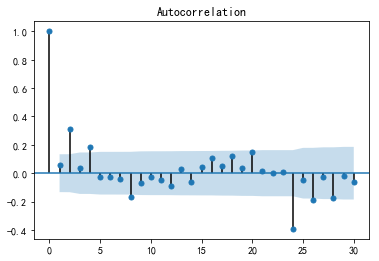

<Figure size 1080x432 with 0 Axes>

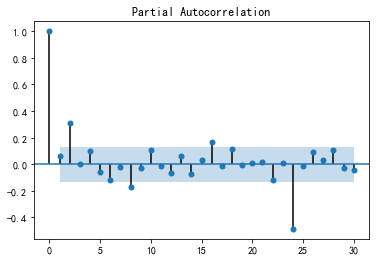

In [73]:
y = data2_T.iloc[:,79]
dy_24 = y.diff(24).dropna().astype('float')
plt.figure(figsize=(15,6))
plot_acf(dy_24,lags=30)
plt.show()
plt.figure(figsize=(15,6))
# tsplot(cpi_d,lags=30)
plot_pacf(dy_24,lags=30)
plt.show()

In [15]:
# 白噪声检验
acorr_ljungbox(y.diff().diff(24).dropna().astype('float'),lags=1)

(array([33.79891371]), array([6.11129783e-09]))

In [16]:
# 平稳性检验

adfuller(dy_24)

(-6.321308211545783,
 3.0613400721407015e-08,
 2,
 213,
 {'1%': -3.461429147102264,
  '5%': -2.875206950587861,
  '10%': -2.5740544497344002},
 1915.8951402386149)

In [67]:
out = pd.DataFrame()
fore_out=pd.DataFrame()
n = 337
print('正在预测第 {} 个供货商,请稍候...'.format(n+1),end='    ')
y = data2_T.iloc[:,n]
dy_24 = y.diff(24).dropna().astype('float')

# 模型定阶
par = get_pdq(dy_24)

aic = pd.DataFrame([x[2] for x in par])
i = aic.idxmin().loc[0]
order = par[i][0]
seasonal_order = par[i][1]
print(' --> 最优预测模型为：ARIMA{}*{}'.format(order,seasonal_order))

# 向后预测24周
fore,pre=forecast_y(par,dy_24)

#还原数据
t = pd.period_range('2021-9-12', periods=24, freq='w')
index = pd.PeriodIndex(t,freq='d')
fore.index = index
tem = y[-24:].copy()
tem.index = index
#     y = data2_T.iloc[:,n]
#     forecast =pd.concat([y,fore+tem])
#     plt.figure(figsize=[16,6])
#     plt.plot(forecast.dropna(),'g')
#     plt.plot(y,'r')
#     plt.show()
te = fore.astype('int')+tem
te[te<0]=0
new_y = pd.concat([y.shift(24).dropna().astype('float')+pre.astype('float'),te],axis=0)
new_y[new_y<0]=0

out['S'+str(n+1).zfill(3)] = te
fore_out['S'+str(n+1).zfill(3)] = new_y

正在预测第 338 个供货商,请稍候...     --> 最优预测模型为：ARIMA(0, 1, 1)*(0, 1, 1, 24)


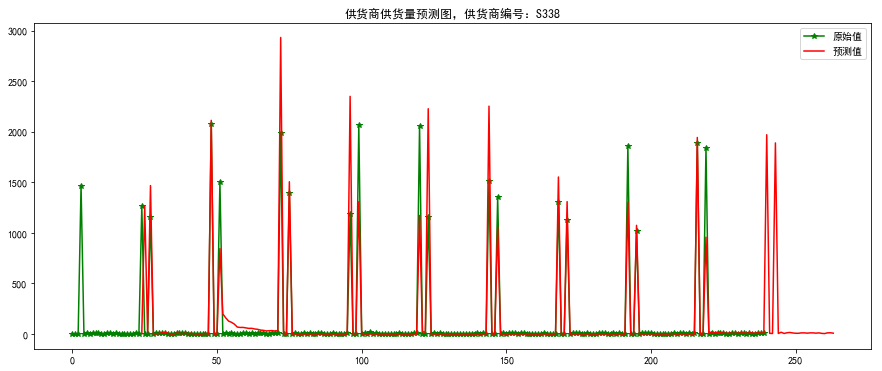

In [70]:
# 预测效果图
pp=pd.concat([fore_out,y],axis=1)
pp.reset_index(drop=True,inplace=True)

plt.close()
plt.figure(figsize=[15,6])

plt.plot(pp.iloc[:,1],'-*g')
plt.plot(pp.iloc[:,0],'r')

plt.title('供货商供货量预测图，供货商编号：S%s'%(str(n+1).zfill(3)))
plt.legend(["原始值","预测值"])

plt.show()
